In [1]:
#import all the library
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import time

In [6]:
class ComputeDisparity:
    #class attribute
    #1. left image
    #2. right image
    #3. ground true disparity map
    #4. compute true disparity map 
    #5. compute time
    #6. process_result 
    
    def __init__(self, left_filepath, right_filepath, disparity_filepath):
        self.left_image = cv2.cvtColor(cv2.imread(left_filepath),cv2.COLOR_BGR2GRAY)
        self.right_image = cv2.cvtColor(cv2.imread(right_filepath),cv2.COLOR_BGR2GRAY)
#         imglef = np.expand_dims(left_filepath, axis=0)
#         imgrig = np.expand_dims(right_filepath, axis=0)
#         print(imglef)
#         print(imgrig)
#         self.left_image = cv2.imread(imglef, -1)
#         self.right_image = cv2.imread(imgrig, -1)
#         self.left_image = left_filepath
#         self.right_image = right_filepath
#         print(self.left_image)
#         print(self.right_image)
        
        self.g_disparity_map = cv2.imread(disparity_filepath,-1)/256
        self.c_disparity_map = None
        self.com_time = 0

    def get_left(self):
        return self.left_image
    
    def get_right(self):
        return self.right_image
    
    def get_g_disparity_map(self):
        return self.g_disparity_map
    
    def get_c_disparity_map(self):
        return self.c_disparity_map
    
    def get_process_result(self):
        return self.process_result 
    
    def compute_sad_disparity(self):
        start = time.time()
        ##StereoBM uses SAD
        stereoBM = cv2.StereoBM_create(numDisparities = 32, blockSize = 21)
        disparityBM = stereoBM.compute(self.left_image, self.right_image)
        self.c_disparity_map = disparityBM/16
        end = time.time()
        self.com_time = end - start
        return disparityBM
    
    def compute_sgbm_disparity(self):
        start = time.time()
        stereoSGBM = cv2.StereoSGBM_create(numDisparities = 32,blockSize = 21)
        disparitySGBM = stereoSGBM.compute(self.left_image, self.right_image)
        self.c_disparity_map = disparitySGBM/16
        end = time.time()
        self.com_time = end - start
        return disparitySGBM
        
    def compute_ssd_disparity(self, kernel):
        start = time.time()
        left = np.asarray(self.left_image)
        right = np.asarray(self.right_image)    
        h = self.right_image.shape[0]
        w = self.right_image.shape[1]

        depth = np.zeros((w, h), np.uint8)
        depth.shape = h, w
        kernel_half = int(kernel / 2)
        for y in range(kernel_half, h - kernel_half):  
            print("\rProcessing.. %d%% complete"%(y / (h - kernel_half) * 100), end="", flush=True)
            for x in range(kernel_half, w - kernel_half):
                smallest_ssd = 65534
                smallest_pair_x = x
                
                for right_w in range(kernel_half, w - kernel_half): 
                    ssd = 0
                    ssd_temp = 0                    
                    for v in range(-kernel_half, kernel_half+1):
                        for u in range(-kernel_half, kernel_half+1):
                            ssd_temp = left[y+v, x+u] - right[y+v,right_w+u] 
                            ssd += ssd_temp * ssd_temp

                    if ssd < smallest_ssd:
                        smallest_ssd  = ssd
                        smallest_pair_x = right_w
                
                #depth[y,x] =  left[y,x]-right[y,smallest_pair_x]
                depth[y,x] =  abs(x-smallest_pair_x)

        self.process_result = depth
        self.c_disparity_map = depth
        end = time.time()
        self.com_time = end - start
        return depth
    

    def compute_ssd_disparity_acc2(self, kernel, search_range):
        start = time.time()
        left = np.asarray(self.left_image)
        right = np.asarray(self.right_image)    
        h = self.right_image.shape[0]
        w = self.right_image.shape[1]

        depth = np.zeros((w, h), np.uint8)
        depth.shape = h, w
        
        kernel_half = int(kernel / 2)
        for y in range(kernel_half, h - kernel_half):  
            print("\rProcessing.. %d%% complete"%(y / (h - kernel_half) * 100), end="", flush=True)
            for x in range(kernel_half, w - kernel_half):
                smallest_ssd = 65534
                smallest_pair_x = x
                
                start = kernel_half
                if x-search_range<kernel_half:start = kernel_half
                else: start = x-search_range
                
                end = w - kernel_half
                if x + search_range > w - kernel_half: end = w - kernel_half
                else: end = x + int(search_range/2)
                for right_w in range(start, end): 
                    ssd = 0
                    ssd_temp = 0                    
                    for v in range(-kernel_half, kernel_half+1):
                        for u in range(-kernel_half, kernel_half+1):
                            ssd_temp = left[y+v, x+u] - right[y+v,right_w+u] 
                            ssd += ssd_temp * ssd_temp

                    if ssd < smallest_ssd:
                        smallest_ssd  = ssd
                        smallest_pair_x = right_w
                
                #depth[y,x] =  left[y,x]-right[y,smallest_pair_x]
                depth[y,x] =  abs(smallest_pair_x-x)

        self.process_result = depth
        self.c_disparity_map = depth
        end = time.time()
        self.com_time = end - start
        return depth
    
    def compute_ssd_disparity_acc(self, kernel):
        start = time.time()
        left = np.asarray(self.left_image)
        right = np.asarray(self.right_image)    
        h = self.right_image.shape[0]
        w = self.right_image.shape[1]

        depth = np.zeros((w, h), np.uint8)
        depth.shape = h, w
        kernel_half = int(kernel / 2)
        for y in range(kernel_half, h - kernel_half):  
            print("\rProcessing.. %d%% complete"%(y / (h - kernel_half) * 100), end="", flush=True)
            for x in range(kernel_half, w - kernel_half):
                smallest_ssd = 65534
                smallest_pair_x = x
                #Compute the matrix in the left graph
                left_matrix = self.left_image[y-kernel_half:y+kernel_half,x-kernel_half:x+kernel_half]
                for right_w in range(kernel_half, w - kernel_half): 
                    #compute the right matrix 
                    right_matrix = self.right_image[y-kernel_half:y+kernel_half,right_w-kernel_half:right_w+kernel_half]
                    
                    #calculate the ssd with left and right matrix
                    current_ssd = np.sum(np.square(left_matrix-right_matrix))
                    
                    if current_ssd < smallest_ssd:
                        smallest_ssd  = current_ssd
                        smallest_pair_x = right_w
                    
                    
                depth[y,x] =  np.absolute(x-smallest_pair_x)


        self.process_result = depth
        self.c_disparity_map = depth
        end = time.time()
        self.com_time = end - start
        return depth
    
    
    def compute_nnd_disparity(self, kernel):
        start = time.time()
        left = np.asarray(self.left_image)
        right = np.asarray(self.right_image)  
        
        h = self.right_image.shape[0]
        w = self.right_image.shape[1]
        
        depth = np.zeros((w, h), np.uint8)
        depth.shape = h, w
        
        kernel_half = int(kernel / 2)
        
        for y in range(kernel_half, h - kernel_half):              
            print("\rProcessing.. %d%% complete"%(y / (h - kernel_half) * 100), end="", flush=True)
            for x in range(kernel_half, w - kernel_half):
                max_ssd = 0
                max_pair_x = x
                
                for right_w in range(kernel_half, w - kernel_half): 
                    window_left = np.zeros((kernel, kernel), np.uint8)
                    window_right = np.zeros((kernel, kernel), np.uint8)
                    ssd = 0
                    ssd_temp = 0                            
                    for v in range(-kernel_half, kernel_half):
                        for u in range(-kernel_half, kernel_half):
                            window_left[v+kernel_half, u+kernel_half] = left[y+v, x+u]
                            window_right[v+kernel_half, u+kernel_half] = right[y+v, right_w+u]
                            ssd_temp = int(left[y+v, x+u]) * int(right[y+v, right_w+u])  
                            ssd += ssd_temp 
                    
                    ssd = ssd/(np.linalg.norm(window_left)*np.linalg.norm(window_right))
                    if ssd > max_ssd:
                        max_ssd = ssd
                        max_pair_x = right_w
                        
                depth[y,x] =  max_pair_x-x

        self.process_result = depth
        self.c_disparity_map = depth
        end = time.time()
        self.com_time = end - start
        return depth
            
            
    def cal_rms(self):
        sum_of_sub = 0
        num_valid = 0
        for i in range(len(self.g_disparity_map)):
            for j in range(len(self.g_disparity_map[0])):
                if(self.g_disparity_map[i][j]!=0):           
                    sum_of_sub = sum_of_sub+((self.g_disparity_map[i][j]-self.c_disparity_map[i][j])**2)
                    num_valid = num_valid+1
        mse = sum_of_sub/num_valid
        rmse = math.sqrt(mse)
        return rmse
    
    def fra_pixel_dif(self):
        err = 0
        num_valid = 0
        num_lessfour = 0
        num_lesstwo = 0
        num_lessone = 0
        num_lesspoint5 = 0
        num_lesspoint25 = 0
        for i in range(len(self.g_disparity_map)):
            for j in range(len(self.g_disparity_map[0])):
                if(self.g_disparity_map[i][j]!=0):           
                    err = abs(self.g_disparity_map[i][j]-self.c_disparity_map[i][j])
                    num_valid = num_valid+1
                    if err<4: 
                        num_lessfour = num_lessfour+1
                    if err<2:
                        num_lesstwo = num_lesstwo+1
                    if err<1: 
                        num_lessone = num_lessone+1
                    if err<0.5:
                        num_lesspoint5 = num_lesspoint5+1
                    if err<0.25:
                        num_lesspoint25 = num_lesspoint25+1
                    
        return num_lessfour/num_valid, num_lesstwo/num_valid,num_lessone/num_valid, num_lesspoint5/num_valid,num_lesspoint25/num_valid
        
    def analysis(self):
        #calculate the rms error betweem the value in your disparity map and those in the ground truth. 
        four, two, one, point5, point25 = self.fra_pixel_dif()
        print("the root mean squre is: "+str(self.cal_rms()))
        print("The fractions of pixels with the error less than 4 is: "+str(four))
        print("The fractions of pixels with the error less than 2 is: "+str(two))
        print("The fractions of pixels with the error less than 1 is: "+str(one))
        print("The fractions of pixels with the error less than 0.5 is: "+str(point5))
        print("The fractions of pixels with the error less than 0.25 is: "+str(point25))
        print("The computation time is:"+str(self.com_time))
    
    
    #copy from workshop2 worksheet COMP90086 Computer Vision
    #option=0 is the right image
    #option=1 is the left image
    #option=2 is self computed disparity map
    #option=3 is ground true disparity map
    def imshow(self, option,  *args, **kwargs):
        if option==0:
                image = self.left_image
        elif option==1:
                image = self.right_image
        elif option==2:
                image = self.c_disparity_map
        elif option==3:
                image = self.g_disparity_map
        else:
                print("There is no such option")
                return
            
        if len(image.shape) == 3:
          # Height, width, channels
          # Assume BGR, do a conversion since 
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
          # Height, width - must be grayscale
          # convert to RGB, since matplotlib will plot in a weird colormap (instead of black = 0, white = 1)
          image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        # Draw the image
        plt.imshow(image, *args, **kwargs)
        # We'll also disable drawing the axes and tick marks in the plot, since it's actually an image
        plt.axis('off')
        # Make sure it outputs
        plt.show()


In [3]:
#import the image with its filepath
image_basic = ComputeDisparity("./Dataset/2018-07-09-16-11-56_2018-07-09-16-11-56-702-left.jpg",
                         "./Dataset/2018-07-09-16-11-56_2018-07-09-16-11-56-702-right.jpg", 
                         "./Dataset/2018-07-09-16-11-56_2018-07-09-16-11-56-702-disparity.png")
image_basicmap = image_basic.compute_ssd_disparity(3)
#image1.compute_sgbm_disparity()
image_basic.analysis()

Processing.. 0% complete

/var/folders/fm/nscr_s1n601dsyhjhm39__th0000gn/T/ipykernel_868/910450245.py:83: RuntimeWarning: overflow encountered in ubyte_scalars
  ssd_temp = left[y+v, x+u] - right[y+v,right_w+u]
/var/folders/fm/nscr_s1n601dsyhjhm39__th0000gn/T/ipykernel_868/910450245.py:84: RuntimeWarning: overflow encountered in ubyte_scalars
  ssd += ssd_temp * ssd_temp


Processing.. 99% completethe root mean squre is: 84.13781633006359
The fractions of pixels with the error less than 4 is: 0.24247580800689741
The fractions of pixels with the error less than 2 is: 0.18640029949290407
The fractions of pixels with the error less than 1 is: 0.1268307070982087
The fractions of pixels with the error less than 0.5 is: 0.07507742572235647
The fractions of pixels with the error less than 0.25 is: 0.04089666360367106
The computation time is:2413.5197699069977


In [4]:
ground = image_basic.get_g_disparity_map()
maxval = np.amax(ground)
maxval

68.734375

In [5]:
ground = image_basic.get_c_disparity_map()
maxval = np.amax(ground)
maxval

255

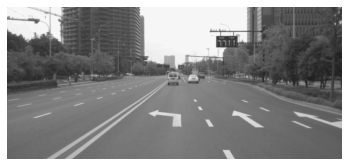

In [7]:
image_basic.imshow(1)

In [ ]:
#import the image with its filepath
image_acc = ComputeDisparity("./Dataset/2018-07-09-16-11-56_2018-07-09-16-11-56-702-left.jpg",
                         "./Dataset/2018-07-09-16-11-56_2018-07-09-16-11-56-702-right.jpg", 
                         "./Dataset/2018-07-09-16-11-56_2018-07-09-16-11-56-702-disparity.png")
image_acc_map = image_acc.compute_ssd_disparity_acc(3)
image_acc.analysis()

In [ ]:
image_acc.imshow(2)

In [7]:
#import the image with its filepath
image_acc2 = ComputeDisparity("./Dataset/2018-07-09-16-11-56_2018-07-09-16-11-56-702-left.jpg",
                         "./Dataset/2018-07-09-16-11-56_2018-07-09-16-11-56-702-right.jpg", 
                         "./Dataset/2018-07-09-16-11-56_2018-07-09-16-11-56-702-disparity.png")
image_acc2_map = image_acc2.compute_ssd_disparity_acc2(3,70)
#image1.compute_sgbm_disparity()
image_acc2.analysis()

Processing.. 0% complete

/var/folders/fm/nscr_s1n601dsyhjhm39__th0000gn/T/ipykernel_868/2222371348.py:129: RuntimeWarning: overflow encountered in ubyte_scalars
  ssd_temp = left[y+v, x+u] - right[y+v,right_w+u]
/var/folders/fm/nscr_s1n601dsyhjhm39__th0000gn/T/ipykernel_868/2222371348.py:130: RuntimeWarning: overflow encountered in ubyte_scalars
  ssd += ssd_temp * ssd_temp


Processing.. 99% completethe root mean squre is: 19.651625551372756
The fractions of pixels with the error less than 4 is: 0.37282328784217633
The fractions of pixels with the error less than 2 is: 0.28125106354014223
The fractions of pixels with the error less than 1 is: 0.19079059320014974
The fractions of pixels with the error less than 0.5 is: 0.11266151629627108
The fractions of pixels with the error less than 0.25 is: 0.06124856776594176
The computation time is:1666247995.291872


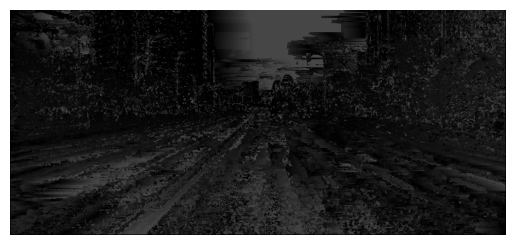

In [8]:
image_acc2.imshow(2)

In [26]:
ground = image_acc2.get_g_disparity_map()

In [27]:
computed = image_acc2.get_c_disparity_map()

In [18]:
computed.shape

(400, 881)

In [20]:
ground.shape

(400, 881)

In [21]:
ground

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [67.046875, 65.84375 ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]])

In [ ]:
#import the image with its filepath
image_window5 = ComputeDisparity("./Dataset/2018-07-09-16-11-56_2018-07-09-16-11-56-702-left.jpg",
                         "./Dataset/2018-07-09-16-11-56_2018-07-09-16-11-56-702-right.jpg", 
                         "./Dataset/2018-07-09-16-11-56_2018-07-09-16-11-56-702-disparity.png")
dis_map = image_window5.compute_ssd_disparity(5)
#image1.compute_sgbm_disparity()
image_window5.analysis()

In [ ]:
#window size=5*5
image_window5.imshow(2)

In [ ]:
#import the image with its filepath
image_ncc = ComputeDisparity("./Dataset/2018-07-09-16-11-56_2018-07-09-16-11-56-702-left.jpg",
                         "./Dataset/2018-07-09-16-11-56_2018-07-09-16-11-56-702-right.jpg", 
                         "./Dataset/2018-07-09-16-11-56_2018-07-09-16-11-56-702-disparity.png")
ncc_dis_map = image_ncc.compute_nnd_disparity(3)
#image1.compute_sgbm_disparity()
image_ncc.analysis()

In [ ]:
image_ncc.imshow(2)